## Product pricer
A model that can estimate how much somthing costs based on its description.

Step-1 - Data Curation


In [7]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

In [8]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
os.environ['HUGGINGFACEHUB_API_TOKEN'] = os.getenv('HUGGINGFACEHUB_API_TOKEN')


In [15]:
# Log in to Huggingface
hf_token = os.environ['HUGGINGFACEHUB_API_TOKEN']
login(hf_token,add_to_git_credential=True)

In [18]:
#from items import Item
%matplotlib inline

In [4]:
# Loading the dataset
dataset = load_dataset("McAuley-Lab/Amazon-Review-2023",f"raw_meta_Electronics", split="full", trust_remote_code=True)

In [15]:
# Categories of data available
'''
ValueError: BuilderConfig 'raw_meta_Elects' not found. Available: ['raw_meta_All_Beauty', 'raw_meta_Arts_Crafts_and_Sewing', 'raw_meta_Cell_Phones_and_Accessories', 'raw_meta_Electronics', 'raw_meta_Gift_Cards', 'raw_meta_Handmade_Products', 'raw_meta_Industrial_and_Scientific', 'raw_meta_Musical_Instruments', 'raw_meta_Toys_and_Games']
'''

"\nValueError: BuilderConfig 'raw_meta_Elects' not found. Available: ['raw_meta_All_Beauty', 'raw_meta_Arts_Crafts_and_Sewing', 'raw_meta_Cell_Phones_and_Accessories', 'raw_meta_Electronics', 'raw_meta_Gift_Cards', 'raw_meta_Handmade_Products', 'raw_meta_Industrial_and_Scientific', 'raw_meta_Musical_Instruments', 'raw_meta_Toys_and_Games']\n"

In [16]:
print(f"Number of Electronics : {len(dataset)}")

Number of Electronics : 1610012


In [5]:
# Investigate a particular datapoint
datapoint = dataset[2]
datapoint

{'main_category': 'Computers',
 'title': 'Digi-Tatoo Decal Skin Compatible With MacBook Pro 13 inch (Model A2338/ A2289/ A2251) - Protective and Decorative Full Body Laptop Skin Decal Sticker, Anti-Scratch Vinly Skin Sticker Wrap [Fresh Marble]',
 'average_rating': 4.5,
 'rating_number': 246,
 'features': ['WARNING: Please IDENTIFY MODEL NUMBER on the bottom of your Macbook. Only fits for model A2338/ A2289/ A2251 (Macbook Pro 13" w/ Touch Bar, 2022/2020 release).',
  'Extra Care Yet Not Bulky. Our skin is capable of protecting the surface of your Macbook from daily scratches, dust, oil, water and fingerprint. Your Macbook remains fresh some years later.',
  'Elegant Style. Our stylish design and printing tech give your Macbook a 360 degree decorative and impressive looking. Take it out and get tons of compliments.',
  'Easy Apply. Easy, bubble-free installation and goo-free removal. Installation guide is well documented in paper material and video format.',
  '100% SATISFACTION GUARAN

In [6]:
# Investigate
print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

Digi-Tatoo Decal Skin Compatible With MacBook Pro 13 inch (Model A2338/ A2289/ A2251) - Protective and Decorative Full Body Laptop Skin Decal Sticker, Anti-Scratch Vinly Skin Sticker Wrap [Fresh Marble]
[]
['WARNING: Please IDENTIFY MODEL NUMBER on the bottom of your Macbook. Only fits for model A2338/ A2289/ A2251 (Macbook Pro 13" w/ Touch Bar, 2022/2020 release).', 'Extra Care Yet Not Bulky. Our skin is capable of protecting the surface of your Macbook from daily scratches, dust, oil, water and fingerprint. Your Macbook remains fresh some years later.', 'Elegant Style. Our stylish design and printing tech give your Macbook a 360 degree decorative and impressive looking. Take it out and get tons of compliments.', 'Easy Apply. Easy, bubble-free installation and goo-free removal. Installation guide is well documented in paper material and video format.', '100% SATISFACTION GUARANTEED. We use best vinyl material and printing technology and offer premium service. Full refund is guaranteed

In [20]:
# How many have prices. Prices could be missing
prices = 0
for datapoint in dataset:
    try :
        price = float(datapoint['price'])
        if price > 0:
            price += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {price/len(dataset)*100:,.1f}%")

There are 0 with prices which is 0.0%


In [21]:
# ALl have prices!

In [22]:
# gather the prices and the length
prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price >0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

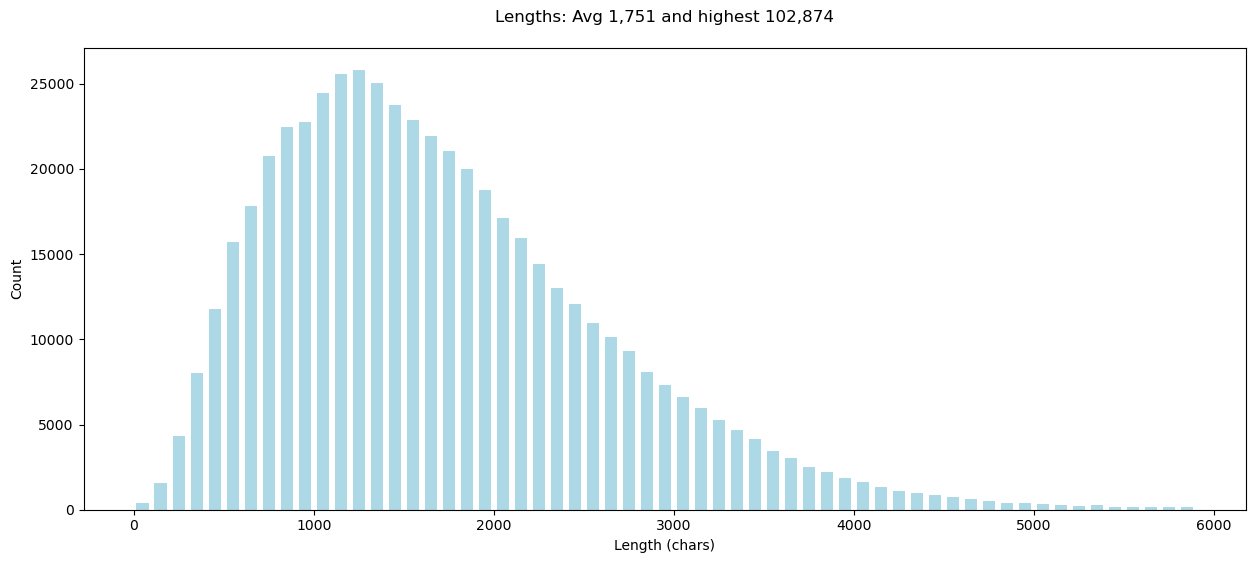

In [23]:
# Plotting distribution of lengths
plt.figure(figsize=(15,6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0,6000,100))
plt.show()

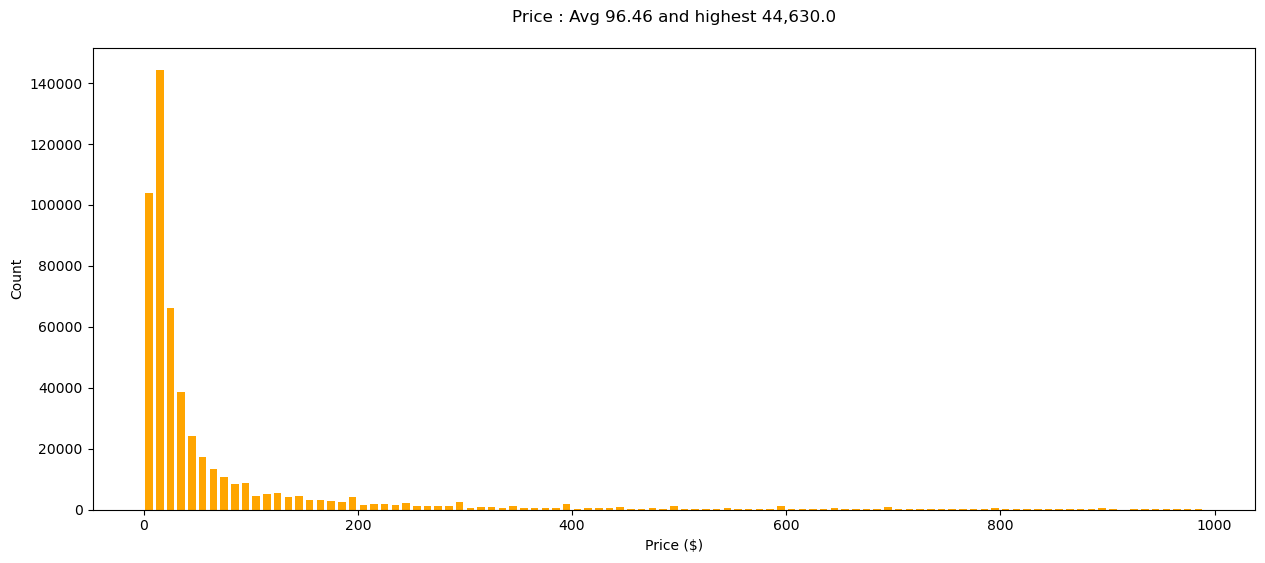

In [24]:
# Plot the distrbution of prices
plt.figure(figsize=(15,6))
plt.title(f"Price : Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0,1000,10))
plt.show()

In [25]:
# Highest priced item
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 44000:
            print(datapoint["title"])
    except ValueError as e:
        pass

Dell PowerEdge C6320 24B 8X E5-2620 V4 8-Core 2.1Ghz 2048GB 24x 1.6TB SSD H330 (Renewed)


### Curation 
Select the items that cost between 1 and 999 USD
Truncate the description and keep 180 token max.
Doing this because I have limited resource. I would have used all if I had DGXs :D

In [10]:
from typing import Optional
from transformers import AutoTokenizer
import re

In [18]:
#BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
BASE_MODEL = "microsoft/Phi-3-mini-4k-instruct"

MIN_TOKENS = 150 # Less than this means no useful content
MAX_TOKENS = 160 # Keeping the lenght to 180 tokens because of resource crunch
MIN_CHARS = 300
CEILING_CHARS = MAX_TOKENS * 7

In [24]:
type(dataset)

datasets.arrow_dataset.Dataset

In [25]:
small_dataset = dataset.select(range(1000))

In [21]:
from items import Item

In [27]:
items = []
for datapoint in small_dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            item = Item(datapoint,price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 413 items


In [40]:
print(items[90].prompt)

How much does this cost to the nearest dollar?

2X SCROY Trackpoint Caps for Lenovo ThinkPad Replacement for Keyboard Mouse (Soft Rim)
These trackpoints are replacements for Lenovo ThinkPad Soft Rim or Classic TrackPoint cap. The TrackPoint is compatible with ThinkPad laptops. This TrackPoint provides the best solution for you to replace the original TrackPoint when it is worn. Soft Rim Inner hole dimensions about 4x4 mm (about 1/8 inch) – Please choose correct size by comparing your old trackpoint size! Fits ThinkPad older models like X200, X201, X220, X230, T400, T410, T410s

Price is $7.00


In [48]:
print(items[90].test_prompt())

How much does this cost to the nearest dollar?

2X SCROY Trackpoint Caps for Lenovo ThinkPad Replacement for Keyboard Mouse (Soft Rim)
These trackpoints are replacements for Lenovo ThinkPad Soft Rim or Classic TrackPoint cap. The TrackPoint is compatible with ThinkPad laptops. This TrackPoint provides the best solution for you to replace the original TrackPoint when it is worn. Soft Rim Inner hole dimensions about 4x4 mm (about 1/8 inch) – Please choose correct size by comparing your old trackpoint size! Fits ThinkPad older models like X200, X201, X220, X230, T400, T410, T410s

Price is $


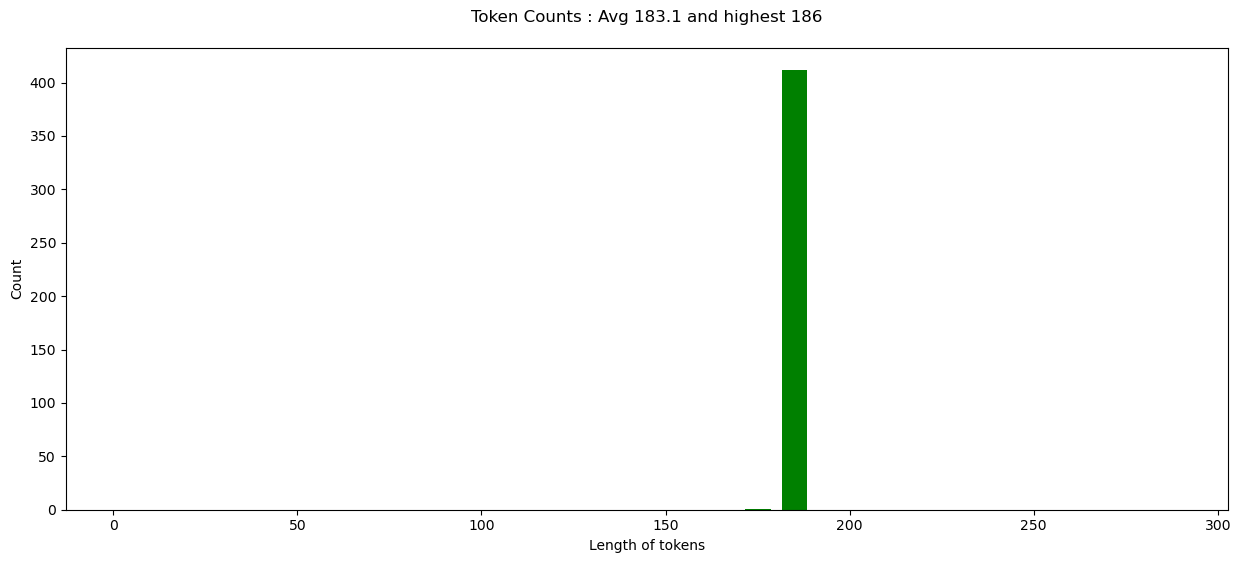

In [52]:
# Plot teh distribution of token counts
tokens = [item.token_count for item in items]
plt.figure(figsize=(15,6))
plt.title(f"Token Counts : Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel("Length of tokens")
plt.ylabel('Count')
plt.hist(tokens,rwidth=0.7, color="green", bins=range(0,300,10))
plt.show()

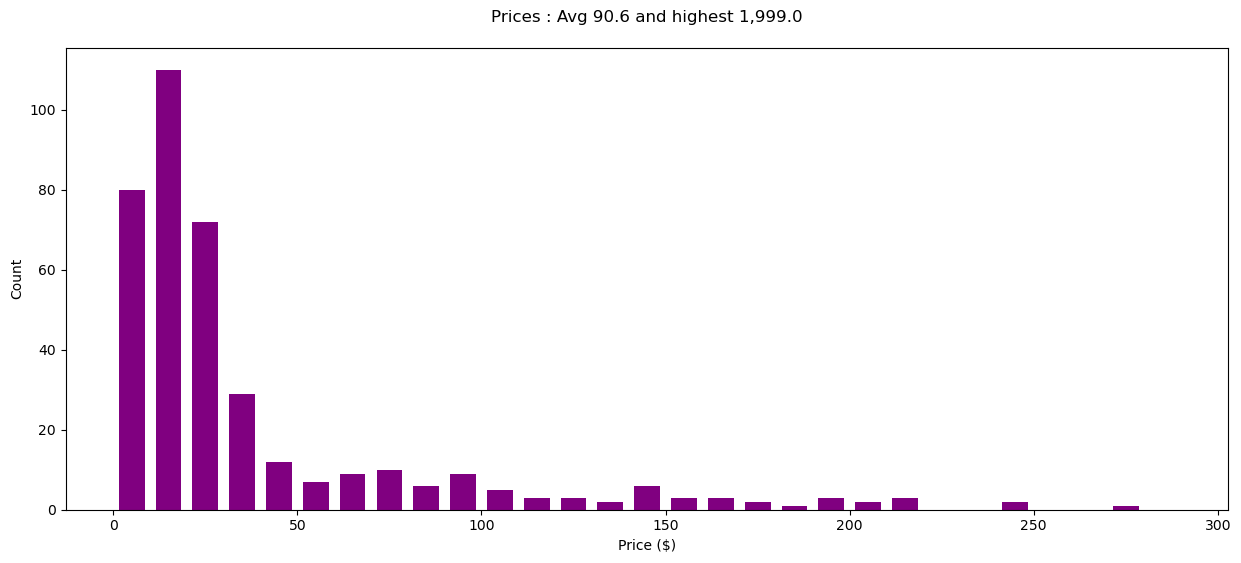

In [54]:
# Distributoin of prices
prices = [item.price for item in items]
plt.figure(figsize=(15,6))
plt.title(f"Prices : Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel("Price ($)")
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color='purple', bins=range(0,300,10))
plt.show()